In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions

In [2]:
def gibbs_bivariate_normal_tf(mu_1=0.0, mu_2=0.0, sig_1=1.0, sig_2=2.0, rho=0.8,
                               x1_init=0.0, x2_init=0.0, n_samples=20_000, 
                               burn_in=2_000, thin=1):
    """
    Gibbs sampling for bivariate normal distribution using TensorFlow.
    
    Parameters:
    -----------
    mu_1, mu_2 : float
        Means (μ₁, μ₂) of the distribution
    sig_1, sig_2 : float
        Standard deviations (σ₁, σ₂)
    rho : float
        Covariance parameter (ρ)
    x1_init, x2_init : float
        Initial values X₁⁽⁰⁾, X₂⁽⁰⁾
    n_samples : int
        Total iterations (including burn-in)
    burn_in : int
        Number of initial samples to discard
    thin : int
        Thinning parameter (keep every thin-th sample)
    
    Returns:
    --------
    samples : ndarray
        Array of shape (n_kept, 2) with samples [X₁, X₂]
    chain : ndarray
        Full chain including burn-in, shape (n_samples, 2)
    
    Algorithm:
    ----------
    At each iteration t:
    1. Sample X₁⁽ᵗ⁾ ~ N(μ₁ + ρ/σ₂² (X₂⁽ᵗ⁻¹⁾ - μ₂), σ₁² - ρ²/σ₂²)
    2. Sample X₂⁽ᵗ⁾ ~ N(μ₂ + ρ/σ₁² (X₁⁽ᵗ⁾ - μ₁), σ₂² - ρ²/σ₁²)
    """
    
    # Convert parameters to TensorFlow constants
    mu_1 = tf.constant(mu_1, dtype=tf.float32)
    mu_2 = tf.constant(mu_2, dtype=tf.float32)
    sig_1 = tf.constant(sig_1, dtype=tf.float32)
    sig_2 = tf.constant(sig_2, dtype=tf.float32)
    rho = tf.constant(rho, dtype=tf.float32)
    
    # Pre-compute conditional variances (constant throughout sampling)
    # Var(X₁|X₂) = σ₁² - ρ²/σ₂²
    # Var(X₂|X₁) = σ₂² - ρ²/σ₁²
    var_1_given_2 = sig_1**2 - (rho**2) / (sig_2**2)
    var_2_given_1 = sig_2**2 - (rho**2) / (sig_1**2)
    sd_1_given_2 = tf.sqrt(var_1_given_2)
    sd_2_given_1 = tf.sqrt(var_2_given_1)
    
    # Initialize chain storage
    chain = tf.TensorArray(dtype=tf.float32, size=n_samples, dynamic_size=False)
    
    # Initialize states
    x1 = tf.constant(x1_init, dtype=tf.float32)
    x2 = tf.constant(x2_init, dtype=tf.float32)
    
    # Main Gibbs sampling loop
    for t in tf.range(n_samples):
        # Step 1: Sample X₁⁽ᵗ⁾ from p(X₁|X₂⁽ᵗ⁻¹⁾)
        # Conditional mean: μ₁ + ρ/σ₂²(x₂ - μ₂)
        mean_1 = mu_1 + (rho / sig_2**2) * (x2 - mu_2)
        x1 = tf.random.normal([], mean=mean_1, stddev=sd_1_given_2)
        
        # Step 2: Sample X₂⁽ᵗ⁾ from p(X₂|X₁⁽ᵗ⁾)
        # Conditional mean: μ₂ + ρ/σ₁²(x₁ - μ₁)
        mean_2 = mu_2 + (rho / sig_1**2) * (x1 - mu_1)
        x2 = tf.random.normal([], mean=mean_2, stddev=sd_2_given_1)
        
        # Store current state
        chain = chain.write(t, tf.stack([x1, x2]))
    
    # Convert to numpy array
    chain = chain.stack().numpy()
    
    # Apply burn-in and thinning
    samples = chain[burn_in::thin]
    
    return samples, chain


In [3]:
def compute_statistics(samples, mu_1=0.0, mu_2=0.0, sig_1=1.0, sig_2=2.0, rho=0.8):
    """
    Compute sample statistics and compare with true parameters.
    
    Parameters:
    -----------
    samples : ndarray
        Array of samples from Gibbs sampler
    mu_1, mu_2, sig_1, sig_2, rho : float
        True distribution parameters
    
    Returns:
    --------
    stats : dict
        Dictionary with sample and true statistics
    """
    sample_mean = np.mean(samples, axis=0)
    sample_std = np.std(samples, axis=0, ddof=1)
    sample_corr = np.corrcoef(samples.T)[0, 1]
    
    stats = {
        'n_samples': len(samples),
        'sample_mean': sample_mean,
        'true_mean': np.array([mu_1, mu_2]),
        'sample_std': sample_std,
        'true_std': np.array([sig_1, sig_2]),
        'sample_corr': sample_corr,
        'true_rho': rho
    }
    
    return stats

In [4]:
def plot_diagnostics(samples, chain, mu_1=0.0, mu_2=0.0, sig_1=1.0, sig_2=2.0):
    """Create diagnostic plots for Gibbs sampling results"""
    fig, axes = plt.subplots(2,3, figsize=(15, 10))
    
    # 1. Joint distribution scatter
    ax = axes[0, 0]
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=1, color='blue')
    ax.set_xlabel('X₁', fontsize=12)
    ax.set_ylabel('X₂', fontsize=12)
    ax.set_title('Joint Distribution (after burn-in)', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # 2. Trace plot for X₁
    ax = axes[0, 1]
    trace_len = min(1000, len(chain))
    ax.plot(chain[:trace_len, 0], linewidth=0.5, alpha=0.7)
    ax.axhline(mu_1, color='r', linestyle='--', linewidth=2, label=f'μ₁={mu_1:.1f}')
    ax.set_xlabel('Iteration t', fontsize=12)
    ax.set_ylabel('X₁⁽ᵗ⁾', fontsize=12)
    ax.set_title(f'Trace Plot for X₁ (first {trace_len})', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Trace plot for X₂
    ax = axes[0, 2]
    ax.plot(chain[:trace_len, 1], linewidth=0.5, alpha=0.7, color='orange')
    ax.axhline(mu_2, color='r', linestyle='--', linewidth=2, label=f'μ₂={mu_2:.1f}')
    ax.set_xlabel('Iteration t', fontsize=12)
    ax.set_ylabel('X₂⁽ᵗ⁾', fontsize=12)
    ax.set_title(f'Trace Plot for X₂ (first {trace_len})', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Marginal distribution of X₁
    ax = axes[1, 0]
    ax.hist(samples[:, 0], bins=50, density=True, alpha=0.6, edgecolor='black')
    x_range = np.linspace(samples[:, 0].min(), samples[:, 0].max(), 200)
    true_pdf = (1/np.sqrt(2*np.pi*sig_1**2)) * np.exp(-0.5*((x_range-mu_1)/sig_1)**2)
    ax.plot(x_range, true_pdf, 'r-', linewidth=2, label='True N(μ₁, σ₁²)')
    ax.set_xlabel('X₁', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Marginal Distribution of X₁', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. Marginal distribution of X₂
    ax = axes[1, 1]
    ax.hist(samples[:, 1], bins=50, density=True, alpha=0.6, color='orange', edgecolor='black')
    x_range = np.linspace(samples[:, 1].min(), samples[:, 1].max(), 200)
    true_pdf = (1/np.sqrt(2*np.pi*sig_2**2)) * np.exp(-0.5*((x_range-mu_2)/sig_2)**2)
    ax.plot(x_range, true_pdf, 'r-', linewidth=2, label='True N(μ₂, σ₂²)')
    ax.set_xlabel('X₂', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Marginal Distribution of X₂', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    
    plt.tight_layout()
    plt.show()



GIBBS SAMPLING FOR BIVARIATE NORMAL DISTRIBUTION

Target: X = (X₁, X₂) ~ N(μ, Σ)
  μ = (0, 0)
  Σ = [[1.0, 0.8], [0.8, 4.0]]

Algorithm:
  1. X₁⁽ᵗ⁾ ~ N(μ₁ + ρ/σ₂² (X₂⁽ᵗ⁻¹⁾ - μ₂), σ₁² - ρ²/σ₂²)
  2. X₂⁽ᵗ⁾ ~ N(μ₂ + ρ/σ₁² (X₁⁽ᵗ⁾ - μ₁), σ₂² - ρ²/σ₁²)

Running Gibbs sampler...

Results:
  Samples generated: 800

Means:
  Sample (X₁, X₂): [-0.0053, -0.0838]
  True   (X₁, X₂): [0.0000, 0.0000]

Standard Deviations:
  Sample (X₁, X₂): [0.9686, 1.9815]
  True   (X₁, X₂): [1.0000, 2.0000]

Correlation:
  Sample: 0.3427
  True ρ: 0.8000

Generating diagnostic plots...


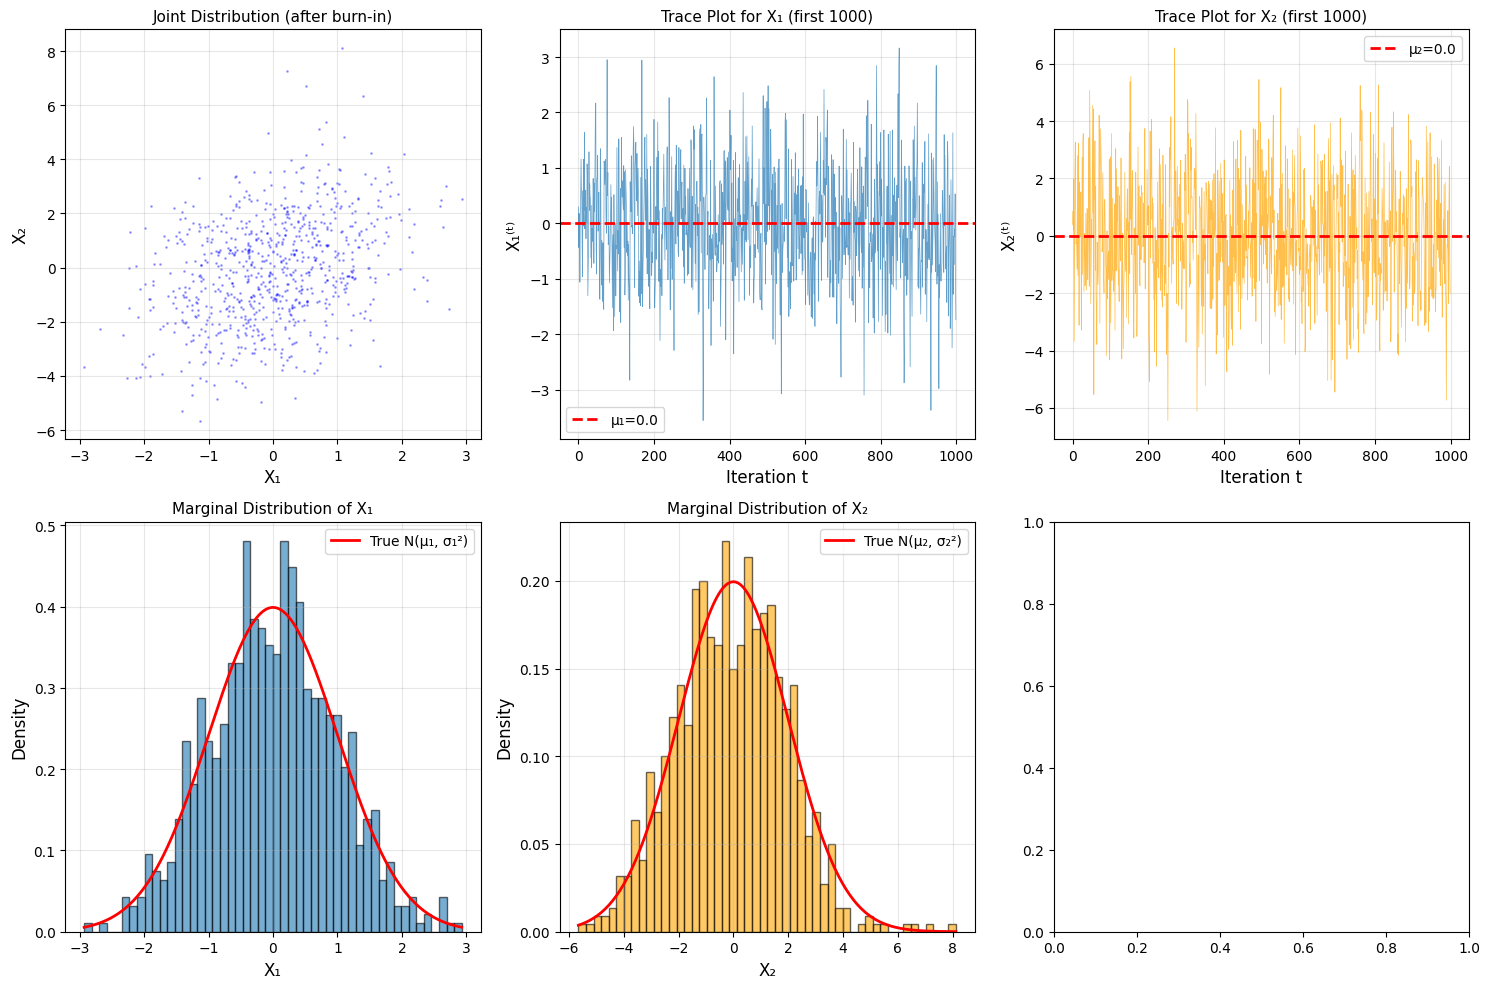

In [5]:
if __name__ == "__main__":
    # Set random seeds
    tf.random.set_seed(42)
    np.random.seed(42)
    
    print("\n" + "="*70)
    print("GIBBS SAMPLING FOR BIVARIATE NORMAL DISTRIBUTION")
    print("="*70)
    print("\nTarget: X = (X₁, X₂) ~ N(μ, Σ)")
    print("  μ = (0, 0)")
    print("  Σ = [[1.0, 0.8], [0.8, 4.0]]")
    print("\nAlgorithm:")
    print("  1. X₁⁽ᵗ⁾ ~ N(μ₁ + ρ/σ₂² (X₂⁽ᵗ⁻¹⁾ - μ₂), σ₁² - ρ²/σ₂²)")
    print("  2. X₂⁽ᵗ⁾ ~ N(μ₂ + ρ/σ₁² (X₁⁽ᵗ⁾ - μ₁), σ₂² - ρ²/σ₁²)")
    print("="*70 + "\n")
    
    # Parameters
    mu_1, mu_2 = 0.0, 0.0
    sig_1, sig_2 = 1.0, 2.0
    rho = 0.8
    
    # Run Gibbs sampler
    print("Running Gibbs sampler...")
    samples, chain = gibbs_bivariate_normal_tf(
        mu_1=mu_1, mu_2=mu_2,
        sig_1=sig_1, sig_2=sig_2,
        rho=rho,
        x1_init=0.0, x2_init=0.0,
        n_samples=5000,
        burn_in=1000,
        thin=5
    )
    
    # Compute statistics
    stats = compute_statistics(samples, mu_1, mu_2, sig_1, sig_2, rho)
    
    # Print results
    print(f"\nResults:")
    print(f"  Samples generated: {stats['n_samples']}")
    print(f"\nMeans:")
    print(f"  Sample (X₁, X₂): [{stats['sample_mean'][0]:.4f}, {stats['sample_mean'][1]:.4f}]")
    print(f"  True   (X₁, X₂): [{stats['true_mean'][0]:.4f}, {stats['true_mean'][1]:.4f}]")
    print(f"\nStandard Deviations:")
    print(f"  Sample (X₁, X₂): [{stats['sample_std'][0]:.4f}, {stats['sample_std'][1]:.4f}]")
    print(f"  True   (X₁, X₂): [{stats['true_std'][0]:.4f}, {stats['true_std'][1]:.4f}]")
    print(f"\nCorrelation:")
    print(f"  Sample: {stats['sample_corr']:.4f}")
    print(f"  True ρ: {stats['true_rho']:.4f}")
    print("="*70)
    
    # Visualize results
    print("\nGenerating diagnostic plots...")
    plot_diagnostics(samples, chain, mu_1, mu_2, sig_1, sig_2)